# Challenge 2

This challenge has two parts:

1. Using RandomForestRegressor with different methods for feature selection
2. Using a RNN for regression


In [1]:
# for data processing and manipulation
import pandas as pd
import numpy as np
import sys
sys.path.append('../') 

# scikit-learn modules for feature selection and model evaluation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# libraries for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#misc
from datetime import datetime
import xlrd
import paths

In [2]:
greenhouse = pd.read_parquet(paths.greenhouse)
resources = pd.read_parquet(paths.resources)
weather = pd.read_parquet(panths.weather)

In [3]:
#Small function to print a bunch of info at once
def print_details(df):
    print(df.dtypes)
    print(df.isna().sum())
    print(df.head(-1))

In [4]:
#The GreenHouseClimate parquet ha dso many Nans I made a function to print extra info and return nan collums
def nan_details(df, treshold = 0):
    nans = list(df.isnull().sum())
    nan_cols = [ (col, nans[idx]) for idx, col in enumerate(df.columns) if nans[idx] > treshold]
    print(*nan_cols, sep='\n')
    to_drop = [col for col, nan in nan_cols]
    return to_drop

In [5]:
#Matches string values of Nan and replaces with np.nan
df = greenhouse
df = df.replace(['^ +NaN'], np.nan, regex=True)

In [6]:
# Prints collums filled almost halfway with Nans and drops them
to_drop = nan_details(df, len(df)*0.4)
df.drop(to_drop, axis=1, inplace=True)

('int_blue_vip', 22397)
('int_farred_vip', 22397)
('int_red_vip', 22397)
('int_white_vip', 22397)
('t_grow_min_sp', 47809)
('water_sup_intervals_sp_min', 41308)


In [7]:
#Prints remainder collums with Nans to be manually inspected
to_drop = nan_details(df)

('AssimLight', 71)
('BlackScr', 71)
('CO2air', 71)
('Cum_irr', 71)
('EC_drain_PC', 71)
('EnScr', 71)
('HumDef', 71)
('PipeGrow', 71)
('PipeLow', 71)
('Rhair', 71)
('Tair', 71)
('Tot_PAR', 71)
('VentLee', 71)
('Ventwind', 71)
('assim_sp', 1944)
('assim_vip', 71)
('co2_dos', 2)
('co2_sp', 1522)
('co2_vip', 71)
('dx_sp', 1585)
('dx_vip', 71)
('int_blue_sp', 198)
('int_farred_sp', 14)
('int_red_sp', 198)
('int_white_sp', 14)
('pH_drain_PC', 71)
('scr_blck_sp', 1940)
('scr_blck_vip', 71)
('scr_enrg_sp', 1939)
('scr_enrg_vip', 71)
('t_grow_min_vip', 71)
('t_heat_sp', 1946)
('t_heat_vip', 71)
('t_rail_min_sp', 1617)
('t_rail_min_vip', 71)
('t_vent_sp', 1960)
('t_ventlee_vip', 71)
('t_ventwind_vip', 71)
('water_sup', 71)
('water_sup_intervals_vip_min', 71)
('window_pos_lee_sp', 1960)
('window_pos_lee_vip', 71)


In [8]:
# Drops all remaining rows with Nans and converts remaidner to numeric
df.dropna(inplace=True)
df = df.apply(pd.to_numeric)
nan_details(df)

[]

In [9]:
# Removes constant valued collumns 
df.drop(columns=df.columns[df.nunique()==1], inplace=True)

In [10]:
#converts excel time to datetime
df['time'] = [xlrd.xldate_as_datetime(time, 0 ) for time in df['%time']]
df.drop(['%time'], axis=1, inplace=True)

## The data

I had the following assumptions for part 1:
- Only the totality of resources used in a day matter, disregarding any temporal dynamics
- The target variable, "elec is the sum of 'ElecHigh' and 'ElecLow' in 'Resources.parquet'

I had the following assumptions for part 2:
- The temporal sequence of each day matters so I used an RNN to try to capture it
- The data was agregated based on the day and month; not summed over the day
- The target variable is the sum of 'ElecHigh' and 'ElecLow'


In [11]:
# Data for part1
df_days = {}
for day in df.groupby(by=[df.time.dt.day, df.time.dt.month]):
    key = pd.to_datetime(day[1].time.values[0]).date()
    df_days[key] = day[1].sum()

In [12]:
# Data for part 2
df_days_unsum = {}
for day in df.groupby(by=[df.time.dt.day, df.time.dt.month]):
    key = pd.to_datetime(day[1].time.values[0]).date()
    df_days_unsum[key] = day[1]

df_temp = df.copy()

In [13]:
dates = [key for key, _ in df_days.items()]

In [14]:
resources_temp = resources.copy()
resources['time']= [xlrd.xldate_as_datetime(time, 0 ) for time in resources['%Time '].values]
resources.drop('%Time ',axis=1, inplace=True)

In [15]:
#Shift target by one day to measure day ahead 
from datetime import timedelta

resources['time'] = resources['time'] + timedelta(days=1)
resources = resources.set_index('time')

In [16]:
resources['elec'] = resources['ElecHigh'] + resources['ElecLow']
resources = resources[['elec']]

## RandomForest with Feature Selection

In [17]:
df_sum = pd.DataFrame.from_dict(df_days, orient='index').sort_index()
df_sum.index.name = 'time'
df_sum.index = pd.to_datetime(df_sum.index)
df_sum.head(-1)

,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,Rhair,...,t_heat_vip,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
time,,,,,,,,,,,,,,,,,,,,,
2019-12-20,5600.0,100.0,71555.0,3.3,498.1,0.0,579.1,0.0,1162.9,8850.6,...,2028.0,0.0,0.0,2254.5,2231.5,2569.0,33.0,127000.0,152.4,152.4
2019-12-21,21600.0,10859.0,174335.0,55.1,1124.3,11742.0,1440.4,0.0,3011.2,19818.7,...,4846.2,0.0,0.0,5204.8,5215.7,6124.2,562.0,288000.0,345.6,345.6
2019-12-22,21600.0,10689.0,175659.0,43.2,1121.9,11555.0,1046.6,0.0,3291.3,22214.7,...,4846.2,0.0,0.0,5203.3,5215.7,6124.2,457.0,288000.0,345.6,345.6
2019-12-23,20100.0,9980.0,167130.0,41.0,1058.0,10130.0,1166.5,0.0,3823.8,20402.7,...,4773.2,0.0,0.0,5061.8,5062.2,5881.8,410.0,273000.0,327.6,327.6
2019-12-24,21600.0,10689.0,175307.0,156.6,1104.2,11555.0,1256.2,0.0,5821.0,21798.2,...,5563.2,0.0,0.0,5835.2,5852.9,6515.0,1751.0,199540.0,345.6,345.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-24,0.0,0.0,192008.0,473.2,3049.6,10517.0,828.1,875.0,6513.9,24627.1,...,6264.3,0.0,0.0,6627.7,6628.4,7270.6,5319.0,11385.0,550.0,540.0
2020-05-25,0.0,0.0,162045.0,331.3,2926.2,8454.0,1914.1,64.2,3229.0,20635.3,...,6265.0,0.0,0.0,6631.5,6629.4,7471.0,3731.0,11385.0,524.0,540.0
2020-05-26,0.0,0.0,156795.0,305.5,2944.1,12114.0,2297.4,54.4,3494.0,19518.0,...,6265.7,0.0,0.0,6632.5,6630.4,7487.4,3451.0,11390.0,536.0,540.0


In [18]:
#No mmissing days in a a row
print(df_sum.index.difference(pd.date_range(df_sum.index.values[0], df_sum.index.values[-1])))
print(resources.index.difference(pd.date_range(resources.index.values[0], resources.index.values[-1])))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [19]:
df = df_sum.join(resources, how='inner')

In [20]:
X = df.drop('elec', 1)
Y = df['elec']

In [21]:
def fit_model(X, Y):
    '''Use a RandomForestRegression for this problem.'''
    
    # define the model to use
    model = RandomForestRegressor(random_state=1337)
    model.fit(X, Y)
    
    return model

In [22]:
def calculate_metrics(model, X_test_scaled, Y_test):
    '''Get model evaluation metrics on the test set.'''
    
    # Get model predictions
    y_predict_r = model.predict(X_test_scaled)
    
    # Calculate evaluation metrics for assesing performance of the model.
    var = explained_variance_score(Y_test, y_predict_r)
    maxe = max_error(Y_test, y_predict_r)
    mae = mean_absolute_error(Y_test, y_predict_r)
    mse = mean_squared_error(Y_test, y_predict_r)
    
    return var, maxe, mae, mse

In [23]:
def train_and_get_metrics(X, Y, test_size = 0.2):
    '''Train a Random Forest Regressor and get evaluation metrics'''
    
    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size,random_state = 1337)

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Call the fit model function to train the model on the normalized features and the diagnosis values
    model = fit_model(X_train_scaled, Y_train)

    # Make predictions on test dataset and calculate metrics.
    var, maxe, mae, mse = calculate_metrics(model, X_test_scaled, Y_test)
   
    return var, maxe, mae, mse

In [24]:
def evaluate_model_on_features(X, Y):
    '''Train model and display evaluation metrics.'''
    
    # Train the model, predict values and get metrics
    var, maxe, mae, mse = train_and_get_metrics(X, Y)

    # Construct a dataframe to display metrics.
    display_df = pd.DataFrame([[var, maxe, mae, mse, X.shape[1]]], columns=["Explained Variance", "Max Error", "MAE", "MSE",'Feature Count'])
    
    return display_df

In [25]:
# Calculate evaluation metrics
all_features_eval_df = evaluate_model_on_features(X, Y)
all_features_eval_df.index = ['All features']

# Initialize results dataframe
results = all_features_eval_df

# Check the metrics
results.head()

,Explained Variance,Max Error,MAE,MSE,Feature Count
All features,0.86853,1.212,0.150545,0.082845,40


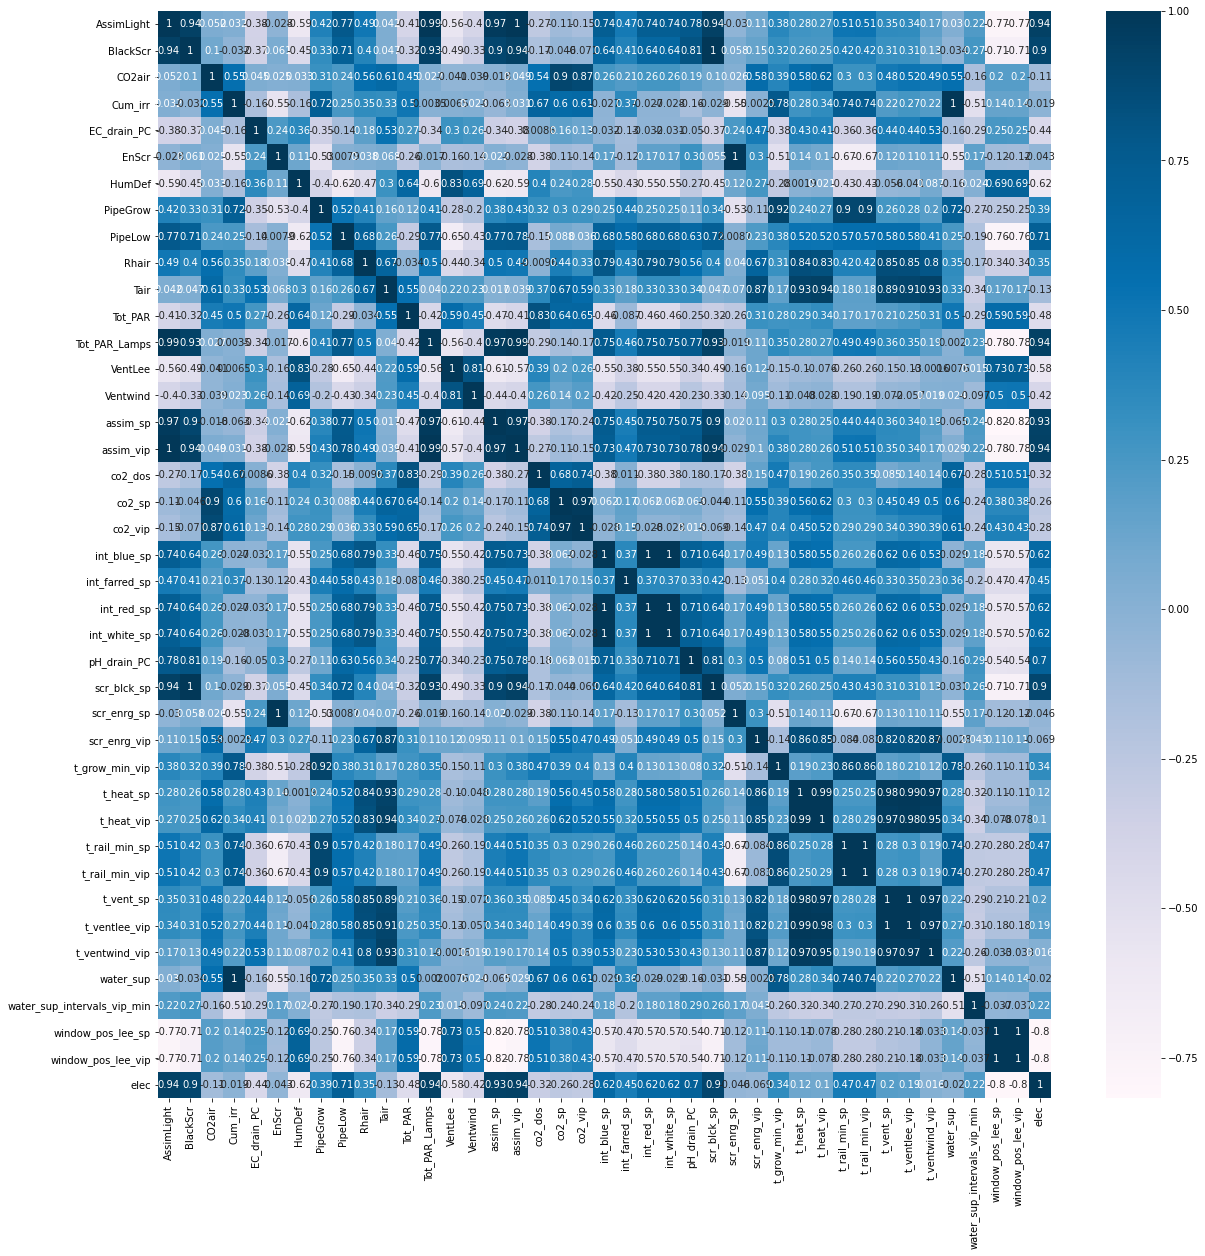

In [26]:
plt.figure(figsize=(20,20))

# Calculate correlation matrix
cor = df.corr() 

# Plot the correlation matrix
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
abs(cor['elec'])

AssimLight                     0.936701
BlackScr                       0.902310
CO2air                         0.114973
Cum_irr                        0.018984
EC_drain_PC                    0.435474
EnScr                          0.043237
HumDef                         0.619713
PipeGrow                       0.390762
PipeLow                        0.714978
Rhair                          0.351452
Tair                           0.127461
Tot_PAR                        0.475792
Tot_PAR_Lamps                  0.937677
VentLee                        0.582696
Ventwind                       0.418083
assim_sp                       0.932544
assim_vip                      0.939003
co2_dos                        0.316971
co2_sp                         0.261590
co2_vip                        0.282547
int_blue_sp                    0.618533
int_farred_sp                  0.452952
int_red_sp                     0.618533
int_white_sp                   0.618737
pH_drain_PC                    0.698409


In [28]:
# Get the absolute value of the correlation
cor_target = abs(cor['elec'])

# Select highly correlated features (thresold = 0.2)
correlated_features = cor_target[cor_target>0.2]

# Collect the names of the features
names = [index for index, value in correlated_features.iteritems()]

# Drop the target variable from the results
names.remove('elec')

# Display the results
print(names)

['AssimLight', 'BlackScr', 'EC_drain_PC', 'HumDef', 'PipeGrow', 'PipeLow', 'Rhair', 'Tot_PAR', 'Tot_PAR_Lamps', 'VentLee', 'Ventwind', 'assim_sp', 'assim_vip', 'co2_dos', 'co2_sp', 'co2_vip', 'int_blue_sp', 'int_farred_sp', 'int_red_sp', 'int_white_sp', 'pH_drain_PC', 'scr_blck_sp', 't_grow_min_vip', 't_rail_min_sp', 't_rail_min_vip', 'water_sup_intervals_vip_min', 'window_pos_lee_sp', 'window_pos_lee_vip']


In [29]:
# Evaluate the model with new features
strong_features_eval_df = evaluate_model_on_features(df[names], Y)
strong_features_eval_df.index = ['Strong features']

# Append to results and display
results = results.append(strong_features_eval_df)
results.head()

,Explained Variance,Max Error,MAE,MSE,Feature Count
All features,0.868530,1.212,0.150545,0.082845,40
Strong features,0.861962,1.213,0.153636,0.086947,28


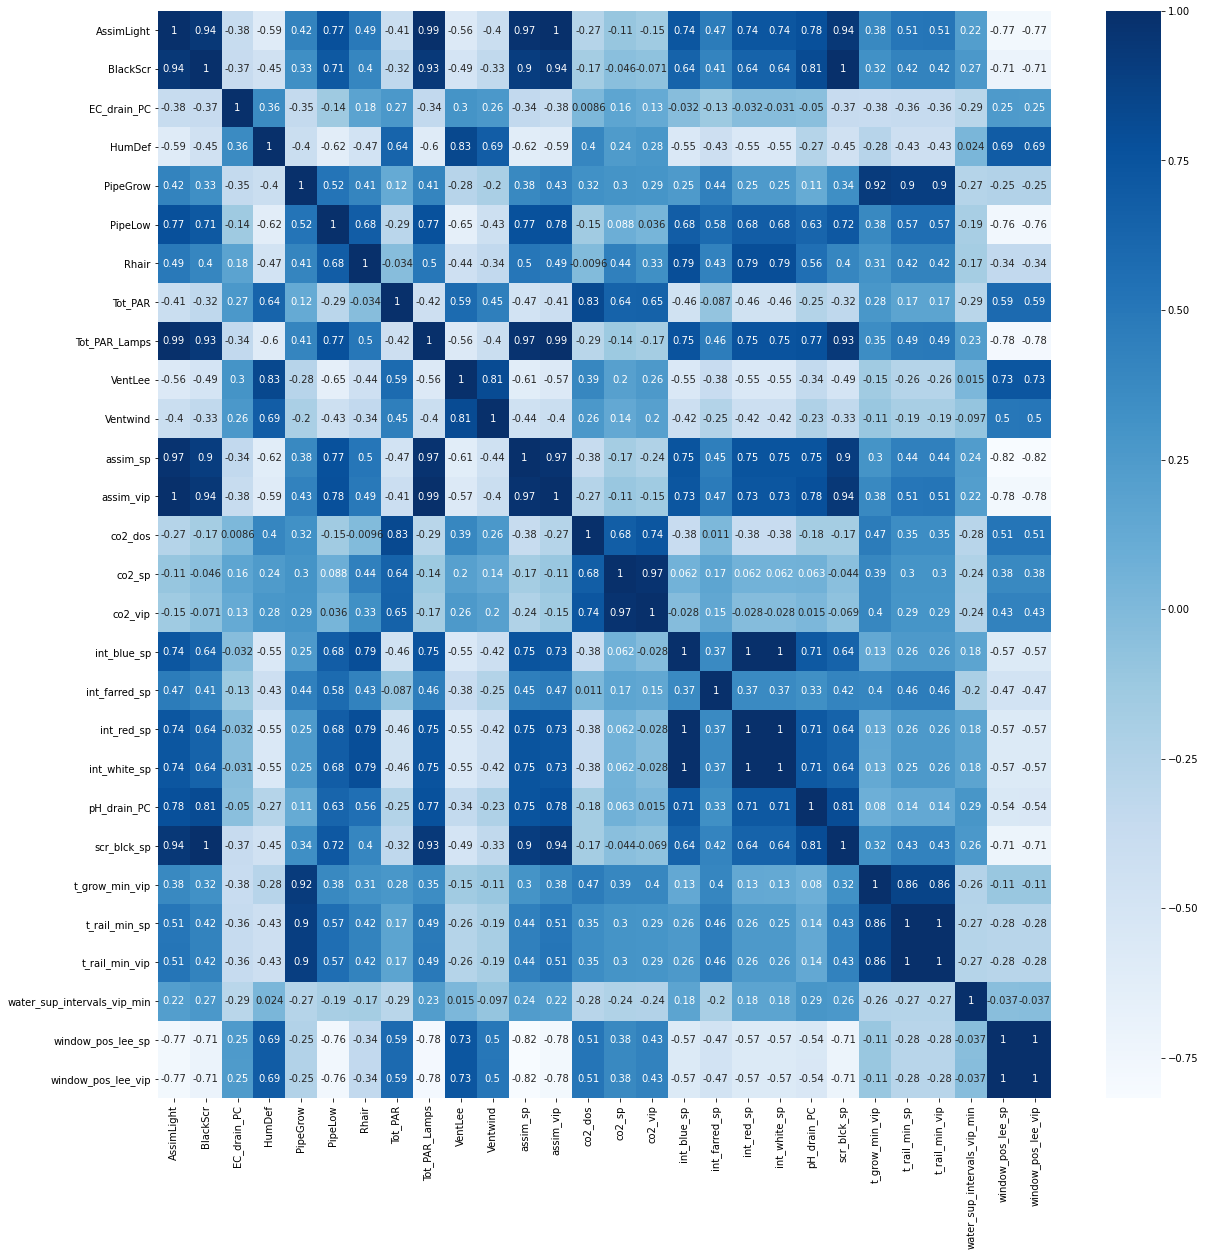

In [30]:
# Set figure size
plt.figure(figsize=(20,20))

# Calculate the correlation matrix for target relevant features that you previously determined
new_corr = df[names].corr()

# Visualize the correlation matrix
sns.heatmap(new_corr, annot=True, cmap=plt.cm.Blues)
plt.show()

In [31]:
def univariate_selection(test_size = 0.2):
    
    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = 1337)
    
    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # User SelectKBest to select top 20 features based on f-test
    selector = SelectKBest(f_regression, k=20)
    
    # Fit to scaled data, then transform it
    X_new = selector.fit_transform(X_train_scaled, Y_train)
    
    # Print the results
    feature_idx = selector.get_support()
    for name, included in zip(df.drop('elec',1 ).columns, feature_idx):
        print("%s: %s" % (name, included))
    
    # Drop the target variable
    feature_names = df.drop('elec',1 ).columns[feature_idx]
    
    return feature_names

In [32]:

univariate_feature_names = univariate_selection()

AssimLight: True
BlackScr: True
CO2air: False
Cum_irr: False
EC_drain_PC: True
EnScr: False
HumDef: True
PipeGrow: False
PipeLow: True
Rhair: False
Tair: False
Tot_PAR: True
Tot_PAR_Lamps: True
VentLee: True
Ventwind: False
assim_sp: True
assim_vip: True
co2_dos: False
co2_sp: False
co2_vip: False
int_blue_sp: True
int_farred_sp: True
int_red_sp: True
int_white_sp: True
pH_drain_PC: True
scr_blck_sp: True
scr_enrg_sp: False
scr_enrg_vip: False
t_grow_min_vip: False
t_heat_sp: False
t_heat_vip: False
t_rail_min_sp: True
t_rail_min_vip: True
t_vent_sp: False
t_ventlee_vip: False
t_ventwind_vip: False
water_sup: False
water_sup_intervals_vip_min: False
window_pos_lee_sp: True
window_pos_lee_vip: True


In [33]:
# Calculate and check model metrics
univariate_eval_df = evaluate_model_on_features(df[univariate_feature_names], Y)
univariate_eval_df.index = ['F-test k=20']

# Append to results and display
results = results.append(univariate_eval_df)
results.head(n=10)

,Explained Variance,Max Error,MAE,MSE,Feature Count
All features,0.868530,1.212,0.150545,0.082845,40
Strong features,0.861962,1.213,0.153636,0.086947,28
F-test k=20,0.852261,1.230,0.163303,0.093077,20


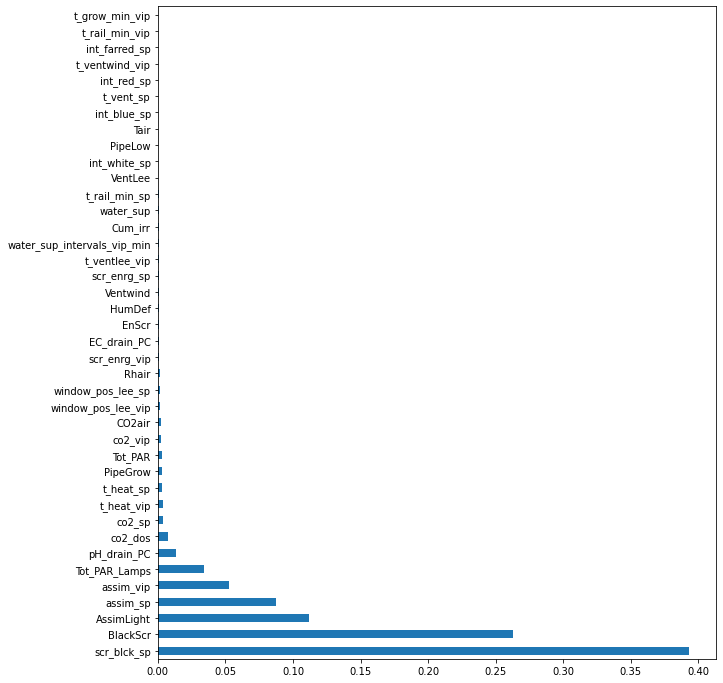

In [34]:
def feature_importances_from_tree_based_model_(test_size=0.2):
    
    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = 1337)
    
    # Define the model to use
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestRegressor()
    model = model.fit(X_train_scaled,Y_train)
    
    # Plot feature importance
    plt.figure(figsize=(10, 12))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.sort_values(ascending=False).plot(kind='barh')
    plt.show()
    
    return model


def select_features_from_model(model):
    
    model = SelectFromModel(model, prefit=True, threshold=0.013)
    feature_idx = model.get_support()
    feature_names = df.drop('elec',1 ).columns[feature_idx]
        
    return feature_names

model = feature_importances_from_tree_based_model_()
feature_imp_feature_names = select_features_from_model(model)

In [35]:
# Calculate and check model metrics
feat_imp_eval_df = evaluate_model_on_features(df[feature_imp_feature_names], Y)
feat_imp_eval_df.index = ['Feature Importance']

# Append to results and display
results = results.append(feat_imp_eval_df)
results.head(n=10)

,Explained Variance,Max Error,MAE,MSE,Feature Count
All features,0.868530,1.212,0.150545,0.082845,40
Strong features,0.861962,1.213,0.153636,0.086947,28
F-test k=20,0.852261,1.230,0.163303,0.093077,20
Feature Importance,0.842844,1.267,0.169030,0.098989,7


In [36]:
def run_l2_regularization(test_size=0.2):
    
    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = 1337)
    
    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Select L2 regulated features from LinearSRV output 
    selection = SelectFromModel(LinearSVR(C=1,dual=True))
    selection.fit(X_train_scaled, Y_train)

    feature_names = df.drop('elec',1 ).columns[(selection.get_support())]
    
    return feature_names

l1reg_feature_names = run_l2_regularization()

/home/mvalente/.config/anaconda3/envs/torcha/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [37]:
# Calculate and check model metrics
l1reg_eval_df = evaluate_model_on_features(df[l1reg_feature_names], Y)
l1reg_eval_df.index = ['L2 Reg']

# Append to results and display
results = results.append(l1reg_eval_df)
results.head(n=10)

,Explained Variance,Max Error,MAE,MSE,Feature Count
All features,0.868530,1.212,0.150545,0.082845,40
Strong features,0.861962,1.213,0.153636,0.086947,28
F-test k=20,0.852261,1.230,0.163303,0.093077,20
Feature Importance,0.842844,1.267,0.169030,0.098989,7
L2 Reg,0.863728,1.280,0.139545,0.085927,14


## RNN Approach

- Takes the rows of a day and passes them through an RNN while cocatenating the hidden rerpesentation and the output to each row (Initialized with zeros before having an hidden representation and an output vector)
- Each cocnatenated version is named feed and the last feed goes through a Linear Layer to output one single value
- The output value  incurrse an MSE loss

In [38]:
# Last minute adition to test RNN with less features
univariate_feature_names = univariate_feature_names.append(pd.Index(['time']))
df_days_unsum_20 = {}
for day in df_temp.groupby(by=[df_temp.time.dt.day, df_temp.time.dt.month]):
    key = pd.to_datetime(day[1].time.values[0]).date()
    df_days_unsum_20[key] = day[1][univariate_feature_names]

In [39]:
# Last minute function to try RNN with less features
def get_rnn_data(df_days_unsum , resources, test_size=0.2):
    for date in resources.index.date:
        if date not in df_days_unsum.keys():
            resources.drop(date, inplace=True)

    Y_train, Y_test = train_test_split(resources, test_size=test_size, random_state=1337)
    X_train = { date: df_days_unsum[date].drop('time',1) for date in Y_train.index.date}
    X_test = { date: df_days_unsum[date].drop('time',1) for date in Y_test.index.date}

    std, mean = [], []
    for _, value in X_train.items():
        std.append(value.values)
        mean.append(value.values)

    std = np.vstack(np.array(std)).std(axis=0)
    mean = np.vstack(np.array(mean)).mean(axis=0)
    for key, value in X_train.items():
        X_train[key] = value - mean / std
    for key, value in X_test.items():
        X_test[key] = value - mean / std

        return X_train, X_test, Y_train, Y_test

In [40]:
def get_training_metrics(history):
  
  
  mse = history['mse']
  val_mse = history['mse_val']

  loss = history['loss']
  val_loss = history['loss_val']

  return mse, val_mse, loss, val_loss

In [41]:
def plot_train_eval(history):
  mse, val_mse, loss, val_loss = get_training_metrics(history)

  mse_plot = pd.DataFrame({"training accuracy":mse, "evaluation accuracy":val_mse})
  mse_plot = sns.lineplot(data=mse_plot)
  mse_plot.set_title('training vs evaluation mse')
  mse_plot.set_xlabel('epoch')
  mse_plot.set_ylabel('mse')
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title('training vs evaluation loss')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.show()

In [42]:
def calculate_metrics_nn(model, val_loader):
    '''Get model evaluation metrics on the test set.'''

    y_pred = []
    y_ground = []
    for x, y in val_loader:
            with torch.no_grad():
                output = model(x.squeeze().float())

                y_pred.append(output.detach().numpy().squeeze())
                y_ground.append(y.numpy().squeeze())
    
    # Calculate evaluation metrics for assesing performance of the model.
    var = explained_variance_score(y_ground, y_pred)
    maxe = max_error(y_ground, y_pred)
    mae = mean_absolute_error(y_ground, y_pred)
    mse = mean_squared_error(y_ground, y_pred)
    
    return var, maxe, mae, mse

In [43]:
from model import ContributionRNN
from dataset import Resources

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
import torch.backends.cudnn as cudnn

In [44]:
# RNN using all features
epochs = 30
batch_size = 1

X_train, X_test, Y_train, Y_test = get_rnn_data(df_days_unsum , resources)

train_loader = DataLoader(Resources(X_train, Y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Resources(X_test, Y_test), batch_size=batch_size, shuffle=True)

model = ContributionRNN(40, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

history = {'mse':  [], 'mse_val': [], 'loss': [], 'loss_val':[]}
for epoch in trange(epochs):
    model.train()
    y_pred = []
    y_ground = []
    losses = []
    for x, y in train_loader:
        optimizer.zero_grad()
        output = model(x.squeeze().float())
        loss = loss_fn(output.squeeze(), y.squeeze().float())
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        y_pred.append(output.detach().numpy().squeeze())
        y_ground.append(y.numpy().squeeze())


    history['loss'].append(sum(losses)/len(losses))
    history['mse'].append(mean_squared_error(y_ground, y_pred))

    model.eval()
    y_pred = []
    y_ground = []
    losses = []
    for x, y in val_loader:
        with torch.no_grad():
            output = model(x.squeeze().float())
            loss = loss_fn(output.squeeze(), y.squeeze().float())

            losses.append(loss.item())
            y_pred.append(output.detach().numpy().squeeze())
            y_ground.append(y.numpy().squeeze())

    history['loss_val'].append(sum(losses)/len(losses))
    history['mse_val'].append(mean_squared_error(y_ground, y_pred))



100%|██████████| 30/30 [03:05<00:00,  6.20s/it]


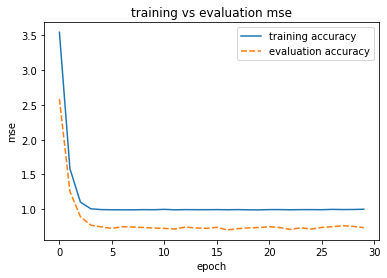

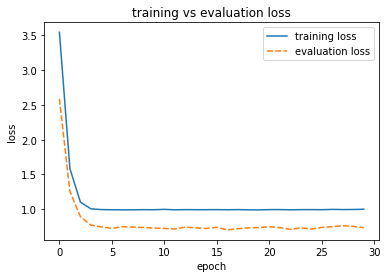

In [45]:
# Same plots, MSE is both loss function and metric
plot_train_eval(history)


In [46]:

metrics = list(calculate_metrics_nn(model,val_loader))
metrics.append(40)
rnn_df = pd.DataFrame([metrics], columns=["Explained Variance", "Max Error", "MAE", "MSE",'Feature Count'])


rnn_df.index = ['ContributionRNN']

# Append to results and display
results = results.append(rnn_df)
results.head(n=10)

,Explained Variance,Max Error,MAE,MSE,Feature Count
All features,0.868530,1.212000,0.150545,0.082845,40
Strong features,0.861962,1.213000,0.153636,0.086947,28
F-test k=20,0.852261,1.230000,0.163303,0.093077,20
Feature Importance,0.842844,1.267000,0.169030,0.098989,7
L2 Reg,0.863728,1.280000,0.139545,0.085927,14
ContributionRNN,0.000000,1.550135,0.762060,0.733928,40


In [47]:
# RNN using F-test univarites features
epochs = 30
batch_size = 1

X_train, X_test, Y_train, Y_test = get_rnn_data(df_days_unsum_20, resources)

train_loader = DataLoader(Resources(X_train, Y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Resources(X_test, Y_test), batch_size=batch_size, shuffle=True)

model = ContributionRNN(20, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

history = {'mse':  [], 'mse_val': [], 'loss': [], 'loss_val':[]}
for epoch in trange(epochs):
    model.train()
    y_pred = []
    y_ground = []
    losses = []
    for x, y in train_loader:
        optimizer.zero_grad()
        output = model(x.squeeze().float())
        loss = loss_fn(output.squeeze(), y.squeeze().float())
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        y_pred.append(output.detach().numpy().squeeze())
        y_ground.append(y.numpy().squeeze())


    history['loss'].append(sum(losses)/len(losses))
    history['mse'].append(mean_squared_error(y_ground, y_pred))

    model.eval()
    y_pred = []
    y_ground = []
    losses = []
    for x, y in val_loader:
        with torch.no_grad():
            output = model(x.squeeze().float())
            loss = loss_fn(output.squeeze(), y.squeeze().float())

            losses.append(loss.item())
            y_pred.append(output.detach().numpy().squeeze())
            y_ground.append(y.numpy().squeeze())

    history['loss_val'].append(sum(losses)/len(losses))
    history['mse_val'].append(mean_squared_error(y_ground, y_pred))



100%|██████████| 30/30 [02:59<00:00,  5.98s/it]


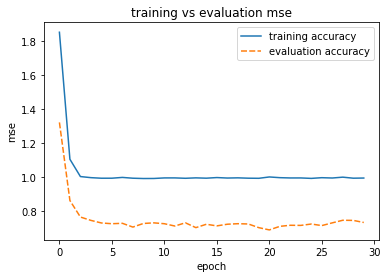

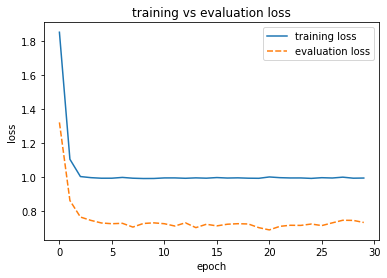

In [48]:
# Same plots, MSE is both loss function and metric
plot_train_eval(history)


In [49]:

metrics = list(calculate_metrics_nn(model,val_loader))
metrics.append(20)
rnn_df = pd.DataFrame([metrics], columns=["Explained Variance", "Max Error", "MAE", "MSE",'Feature Count'])


rnn_df.index = ['ContributionRNN_20']

# Append to results and display
results = results.append(rnn_df)
results.head(n=10)

,Explained Variance,Max Error,MAE,MSE,Feature Count
All features,8.685300e-01,1.212000,0.150545,0.082845,40
Strong features,8.619622e-01,1.213000,0.153636,0.086947,28
F-test k=20,8.522609e-01,1.230000,0.163303,0.093077,20
Feature Importance,8.428438e-01,1.267000,0.169030,0.098989,7
L2 Reg,8.637284e-01,1.280000,0.139545,0.085927,14
ContributionRNN,0.000000e+00,1.550135,0.762060,0.733928,40
ContributionRNN_20,3.330669e-16,1.554948,0.759872,0.730846,20


## Discussion


In [50]:
# another glance at the target variable for a better metric analysis
resources.describe().T

,count,mean,std,min,25%,50%,75%,max
elec,162.0,1.62716,0.966715,0.0,1.3,2.3,2.4,2.4


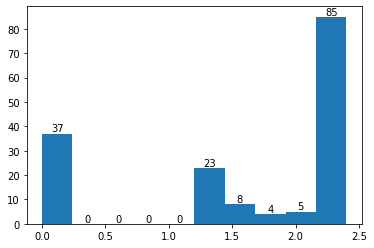

In [51]:
counts, edges, bars = plt.hist(resources['elec'])
plt.bar_label(bars)
plt.show()

- RandomForest outperformed the RNN but not by much
- Day ahead prediction is inherently difficult due to the randomness present in daily events
- A same day prediction is more plausible and works with a max error of '0.5' and a mse of 0.06
- RNN underfits which means it needs more parameteres or more data

## Next step

1. Investigate temporal dynamics and dependencies
2. Develop models capable of achieving better results by capturing better temporal dynamics
3. Do further feature selection, remove highly correlated features to reduce noise in data
